<a href="https://colab.research.google.com/github/intimanjunath/Decision-trees-and-ensemble/blob/main/Decision_Tree_from_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from collections import Counter
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [3]:
#Helper Functions
# Gini Impurity
def gini_impurity(y):
    counts = np.bincount(y)
    probabilities = counts / len(y)
    return 1 - np.sum(probabilities ** 2)

# Entropy
def entropy(y):
    counts = np.bincount(y)
    probabilities = counts / len(y)
    return -np.sum([p * np.log2(p) for p in probabilities if p > 0])

# Information Gain
def information_gain(y, y_left, y_right, impurity_func):
    p = len(y_left) / len(y)
    return impurity_func(y) - p * impurity_func(y_left) - (1 - p) * impurity_func(y_right)

# Split Dataset
def split_dataset(X, y, feature_index, threshold):
    left_indices = X[:, feature_index] <= threshold
    right_indices = X[:, feature_index] > threshold
    return X[left_indices], X[right_indices], y[left_indices], y[right_indices]

# Find Best Split
def find_best_split(X, y, impurity_func):
    best_gain = -1
    best_split = None
    n_features = X.shape[1]

    for feature_index in range(n_features):
        thresholds = np.unique(X[:, feature_index])
        for threshold in thresholds:
            X_left, X_right, y_left, y_right = split_dataset(X, y, feature_index, threshold)
            if len(y_left) == 0 or len(y_right) == 0:
                continue
            gain = information_gain(y, y_left, y_right, impurity_func)
            if gain > best_gain:
                best_gain = gain
                best_split = (feature_index, threshold)
    return best_split

In [4]:
#Decision Tree Class
class DecisionTree:
    def __init__(self, max_depth=None, min_samples_split=2, impurity_func=gini_impurity):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.impurity_func = impurity_func
        self.tree = None

    def fit(self, X, y, depth=0):
        if depth == self.max_depth or len(y) < self.min_samples_split or len(np.unique(y)) == 1:
            return Counter(y).most_common(1)[0][0]

        feature_index, threshold = find_best_split(X, y, self.impurity_func)
        if feature_index is None:
            return Counter(y).most_common(1)[0][0]

        X_left, X_right, y_left, y_right = split_dataset(X, y, feature_index, threshold)
        self.tree = {
            "feature_index": feature_index,
            "threshold": threshold,
            "left": self.fit(X_left, y_left, depth + 1),
            "right": self.fit(X_right, y_right, depth + 1)
        }
        return self.tree

    def predict_single(self, x, tree):
        if isinstance(tree, dict):
            if x[tree["feature_index"]] <= tree["threshold"]:
                return self.predict_single(x, tree["left"])
            else:
                return self.predict_single(x, tree["right"])
        return tree

    def predict(self, X):
        return np.array([self.predict_single(x, self.tree) for x in X])

In [5]:
# Load Wine dataset
data = load_wine()
X, y = data.data, data.target

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display dataset information
print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")

Training samples: 142, Testing samples: 36


In [6]:
# Train the Decision Tree
tree = DecisionTree(max_depth=5, impurity_func=gini_impurity)  # Change impurity_func to entropy for entropy-based splits
tree.fit(X_train, y_train)

# Predict on test data
y_pred = tree.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.9166666666666666


In [8]:
def print_tree(tree, depth=0):
    if isinstance(tree, dict):
        print(f"{'|   ' * depth}Feature {tree['feature_index']} <= {tree['threshold']}")
        print_tree(tree["left"], depth + 1)
        print_tree(tree["right"], depth + 1)
    else:
        print(f"{'|   ' * depth}Predict: {tree}")

print_tree(tree.tree)

Feature 9 <= 3.8
|   Feature 12 <= 985.0
|   |   Feature 2 <= 2.92
|   |   |   Predict: 1
|   |   |   Predict: 0
|   |   Predict: 0
|   Feature 6 <= 1.39
|   |   Predict: 2
|   |   Feature 12 <= 714.0
|   |   |   Feature 0 <= 13.05
|   |   |   |   Predict: 1
|   |   |   |   Predict: 0
|   |   |   Predict: 0


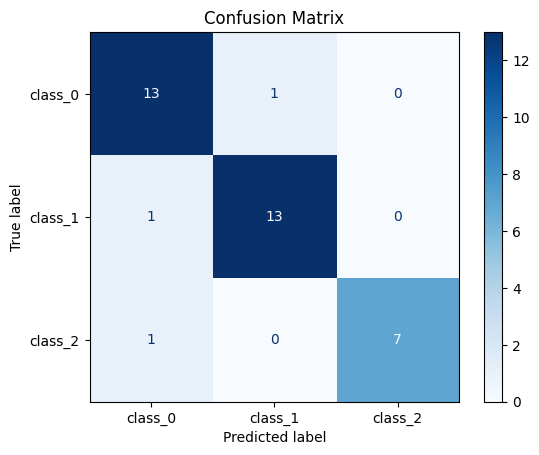

In [10]:
#Confusion Matrix Visualization
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt # Import matplotlib.pyplot

# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=data.target_names)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

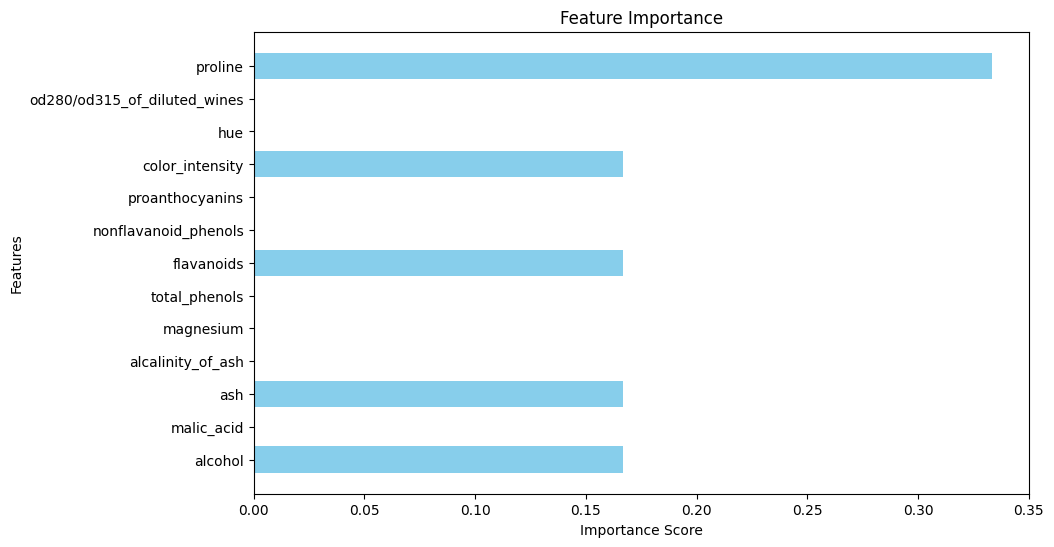

In [11]:
#Feature Importance Calculation
def calculate_feature_importance(tree, feature_importances, depth=0):
    if isinstance(tree, dict):
        feature_index = tree["feature_index"]
        feature_importances[feature_index] += 1  # Increment count for this feature
        calculate_feature_importance(tree["left"], feature_importances, depth + 1)
        calculate_feature_importance(tree["right"], feature_importances, depth + 1)

# Initialize and calculate feature importance
feature_importances = np.zeros(X_train.shape[1])
calculate_feature_importance(tree.tree, feature_importances)

# Normalize importance
feature_importances /= feature_importances.sum()

# Plot Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(data.feature_names, feature_importances, color="skyblue")
plt.title("Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()

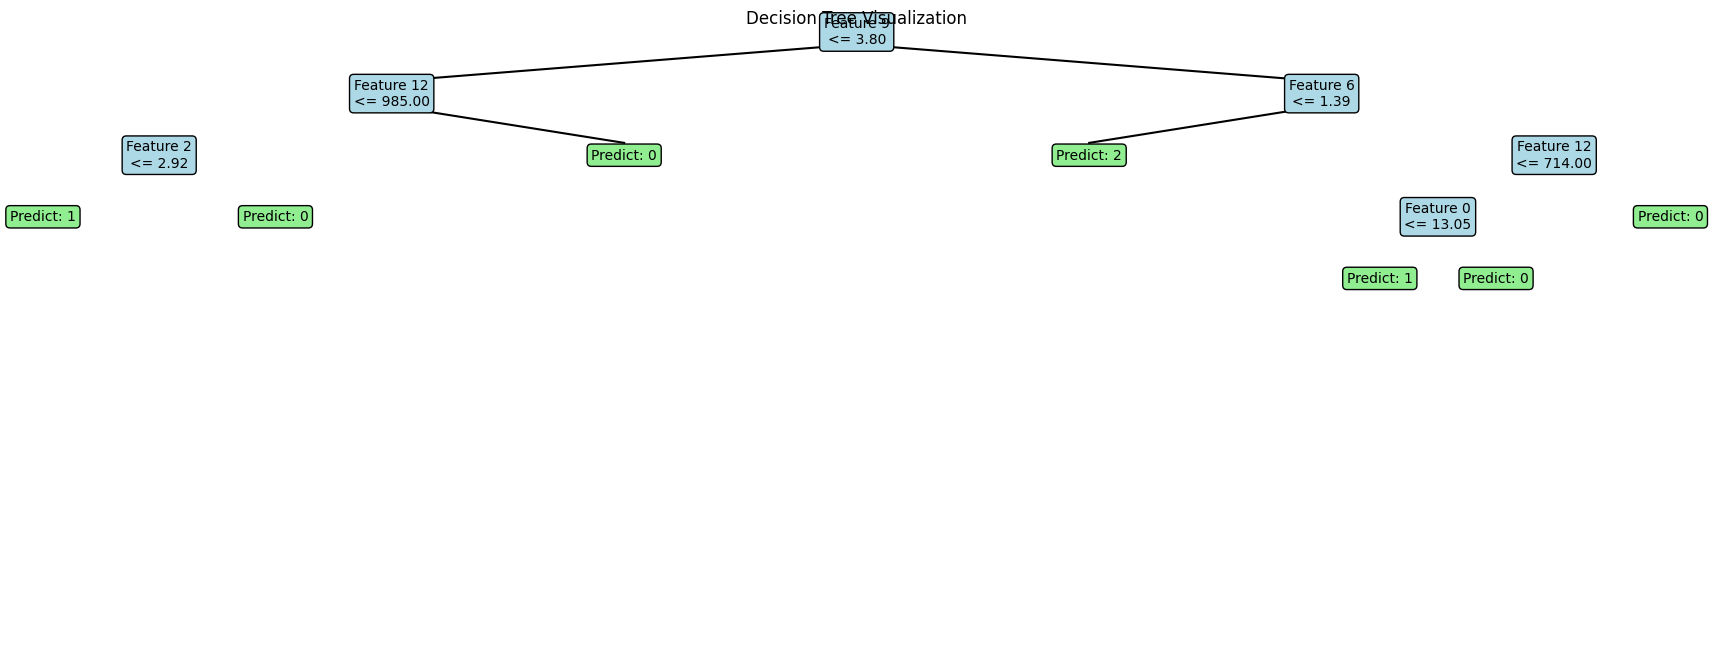

In [12]:
#Decision Tree Visualization with Matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def plot_tree(ax, tree, x=0.5, y=1.0, depth=0, width=1.0):
    if isinstance(tree, dict):
        # Plot decision node
        feature = f"Feature {tree['feature_index']}"
        threshold = f"<= {tree['threshold']:.2f}"
        label = f"{feature}\n{threshold}"
        ax.text(x, y, label, ha="center", va="center", fontsize=10, bbox=dict(boxstyle="round", facecolor="lightblue"))

        # Left branch
        x_left = x - width / 2 ** (depth + 1)
        y_left = y - 0.1
        ax.plot([x, x_left], [y - 0.02, y_left + 0.02], "k-")
        plot_tree(ax, tree["left"], x=x_left, y=y_left, depth=depth + 1, width=width)

        # Right branch
        x_right = x + width / 2 ** (depth + 1)
        y_right = y - 0.1
        ax.plot([x, x_right], [y - 0.02, y_right + 0.02], "k-")
        plot_tree(ax, tree["right"], x=x_right, y=y_right, depth=depth + 1, width=width)
    else:
        # Plot leaf node
        ax.text(x, y, f"Predict: {tree}", ha="center", va="center", fontsize=10, bbox=dict(boxstyle="round", facecolor="lightgreen"))

# Visualize the Decision Tree
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis("off")
plot_tree(ax, tree.tree)
plt.title("Decision Tree Visualization")
plt.show()

<ipython-input-13-f39ad1518c68>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=data.target_names[unique], y=counts, palette="viridis")


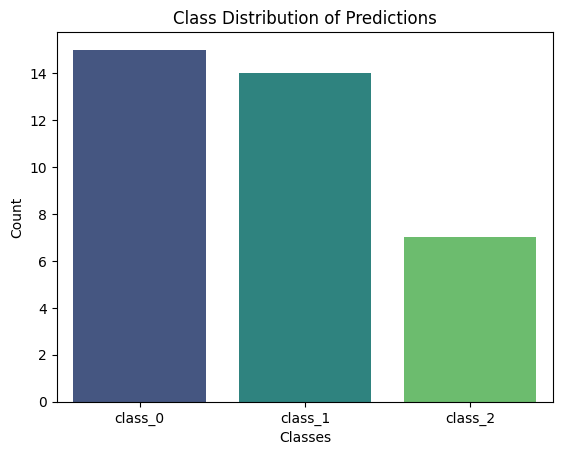

In [13]:
# Class Distribution of Predictions
import seaborn as sns

# Count the predictions
unique, counts = np.unique(y_pred, return_counts=True)

# Plot distribution
sns.barplot(x=data.target_names[unique], y=counts, palette="viridis")
plt.title("Class Distribution of Predictions")
plt.ylabel("Count")
plt.xlabel("Classes")
plt.show()